In [1]:
import pandas as pd

train = pd.read_csv('data/train.csv').drop(columns='id')
test = pd.read_csv('data/test.csv').drop(columns='id')


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pandas.io.formats.style import Styler
import math

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#91013E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn import model_selection
from sklearn import metrics

In [20]:
def log_loss(y_true, y_pred):
    return metrics.log_loss(y_true, y_pred)

In [21]:
%%time
config = {'SEED': 142,
          'FOLDS': 15,
          'N_ESTIMATORS': 700}

xgb_params = {'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'num_class': 11,
              'learning_rate': 0.05,
              'max_depth': 4,
              'early_stopping_rounds': 200,
              'subsample': 0.8,
              'colsample_bytree': 0.1,
              'n_jobs': -1,
              'verbosity': 0,
              'random_state': 42}


mapper = {k: v for v, k in enumerate(train.prognosis.unique())}
X, y = train.drop(columns='prognosis'), train.prognosis.map(mapper)

cv = model_selection.StratifiedKFold(n_splits=config['FOLDS'], shuffle=True, random_state=config['SEED'])
feature_importances_ = pd.DataFrame(index=X.columns)
metric = log_loss
eval_results_ = {}
models_ = []
oof = np.zeros((len(X), 11))

for fold, (fit_idx, val_idx) in enumerate(cv.split(X, y), start=1):

    # Split the dataset according to the fold indexes.
    X_fit = X.iloc[fit_idx]
    X_val = X.iloc[val_idx]
    y_fit = y.iloc[fit_idx]
    y_val = y.iloc[val_idx]

    # XGB .train() requires xgboost.DMatrix.
    # https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.DMatrix
    fit_set = xgb.DMatrix(X_fit, y_fit)
    val_set = xgb.DMatrix(X_val, y_val)
    watchlist = [(fit_set, 'fit'), (val_set, 'val')]

    # Training.
    # https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.training
    eval_results_[fold] = {}
    model = xgb.train(
        num_boost_round=config['N_ESTIMATORS'],
        params=xgb_params,
        dtrain=fit_set,
        evals=watchlist,
        evals_result=eval_results_[fold],
        verbose_eval=False,
        callbacks=[
            EarlyStopping(xgb_params['early_stopping_rounds'],
                          data_name='val', save_best=True)],
    )
    
    val_preds = model.predict(val_set)
    oof[val_idx] = val_preds

    val_score = metric(y_val, val_preds)
    best_iter = model.best_iteration
    print(f'Fold: {blu}{fold:>3}{res}| {metric.__name__}: {blu}{val_score:.5f}{res}'
          f' | Best iteration: {blu}{best_iter:>4}{res}')

    # Stores the feature importances
    feature_importances_[f'gain_{fold}'] = feature_importances_.index.map(model.get_score(importance_type='gain'))
    feature_importances_[f'split_{fold}'] = feature_importances_.index.map(model.get_score(importance_type='weight'))

    # Stores the model
    models_.append(model)

mean_cv_score = metric(y, oof)
print(f'{"*" * 50}\n{red}Mean{res} {metric.__name__}: {red}{mean_cv_score:.5f}')

Fold:   1| log_loss: 1.78811 | Best iteration:  299
Fold:   2| log_loss: 1.75845 | Best iteration:  216
Fold:   3| log_loss: 1.88887 | Best iteration:  282
Fold:   4| log_loss: 1.70149 | Best iteration:  356
Fold:   5| log_loss: 1.77497 | Best iteration:  258
Fold:   6| log_loss: 2.16952 | Best iteration:  143
Fold:   7| log_loss: 1.80796 | Best iteration:  256
Fold:   8| log_loss: 1.90573 | Best iteration:  213
Fold:   9| log_loss: 1.85300 | Best iteration:  251
Fold:  10| log_loss: 1.75681 | Best iteration:  207
Fold:  11| log_loss: 1.82538 | Best iteration:  350
Fold:  12| log_loss: 1.79407 | Best iteration:  367
Fold:  13| log_loss: 2.08783 | Best iteration:  128
Fold:  14| log_loss: 1.83597 | Best iteration:  465
Fold:  15| log_loss: 1.92166 | Best iteration:  133
**************************************************
Mean log_loss: 1.85775
CPU times: user 7min 44s, sys: 2.18 s, total: 7min 46s
Wall time: 39.5 s


In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.io.formats.style import Styler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def stylize_simple(df: pd.DataFrame, caption: str) -> Styler:
    """Waps the min_max_count pivot_table into the Styler.

        Args:
            df: any dataframe (train/test/origin)

        Returns:
            s: the dataframe wrapped into Styler.
    """
    s = df
    s = s.style.set_table_styles(magnify(True)).set_caption(f"{caption}")
    return s

def show_confusion_roc(y: np.array, oof: np.array) -> None:
    """Draws a confusion matrixs.
        
        Args:
            oof: predictions for each fold stacked. 
        
        Returns:
            None
    """
    
    f, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=100)
    cm = confusion_matrix(y, oof.argmax(axis=1))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap=sns.light_palette(palette[2], as_cmap=True), ax=ax, values_format='5g')
    ax.grid(False)
    ax.set_yticklabels(mapper.keys())
    ax.set_xticklabels(mapper.keys(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
def show_confusion_map3k(y: np.array, oof: np.array) -> None:
    """Draws a confusion matrixs.
        
        Args:
            y: true labels.
            oof: predictions for each fold stacked. 
        
        Returns:
            None
    """
    pred_df = np.hstack([np.argsort(-oof)[:, :3], y.values.reshape((-1, 1))])
    frame = pd.DataFrame(pred_df, columns=['y_pred1', 'y_pred2', 'y_pred3', 'y_true'])
    frame['y_pred_correct_@1'] = frame.y_pred1.eq(frame.y_true).astype(int)
    frame['y_pred_correct_@2'] = frame.y_pred2.eq(frame.y_true).astype(int)
    frame['y_pred_correct_@3'] = frame.y_pred3.eq(frame.y_true).astype(int)

    frame['no_correct_preds'] = frame.iloc[:, -3:].sum(1).eq(0)

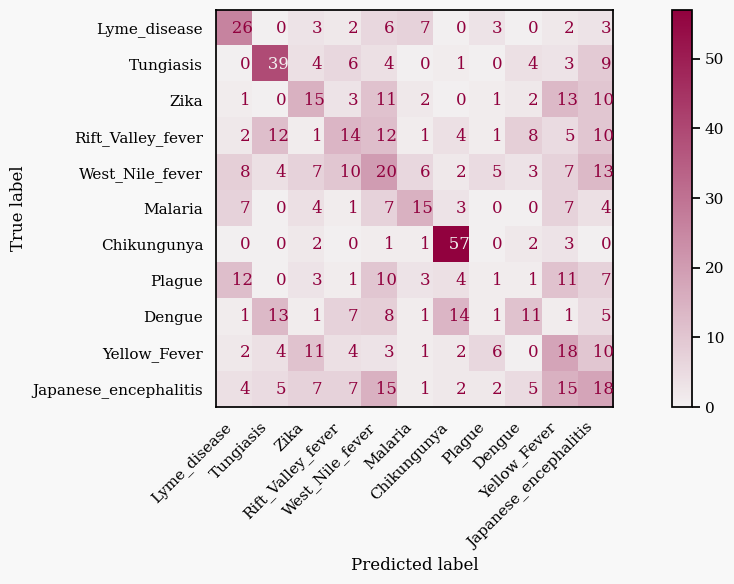

In [34]:
show_confusion_roc(y[:707], oof[:707])